# Week 4: Railway Counter Example

<font color="red">As almost all results are based on our posterior simulation, numerical values might differ from the ones given on the slides!</font>

Load necessary modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Step 1: Data

In [2]:
y1 = np.array([13, 10,  9,  5,  8,  10,  9,  8,  11,  9,  7,  9,  9,  8, 12])
y2 = np.array([3,  8,  8,  10,  6,  5,  3,  5,  2,  9,  3,  10,  4,  2,  8])

## Step 2: Model

\begin{eqnarray*}
    \mu_a, \mu_b &\sim& N(10, 2^2) \\
    \sigma_a, \sigma_b &\sim& \text{Exp}(1/3)\\
    y_a &\sim& N(\mu_a, \sigma_a^2)\\
    y_b &\sim& N(\mu_b, \sigma_b^2)
\end{eqnarray*}

## Step 3: Simulation

In [3]:
with pm.Model() as railway_counter_queue_model:
    μ_b = pm.Normal( 'μ_b', mu=10, sigma=2 )
    μ_a = pm.Normal( 'μ_a', mu=10, sigma=2 )
    σ_b = pm.Exponential( 'σ_b', lam=1/3 )
    σ_a = pm.Exponential( 'σ_a', lam=1/3 )
    y_b = pm.Normal( 'y_b', mu=μ_b, sigma=σ_b, observed=y1 )
    y_a = pm.Normal( 'y_a', mu=μ_a, sigma=σ_a, observed=y2 )
    trace = pm.sample( 1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_b, μ_a, σ_b, σ_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


## Step 4: Diagnose Simulation

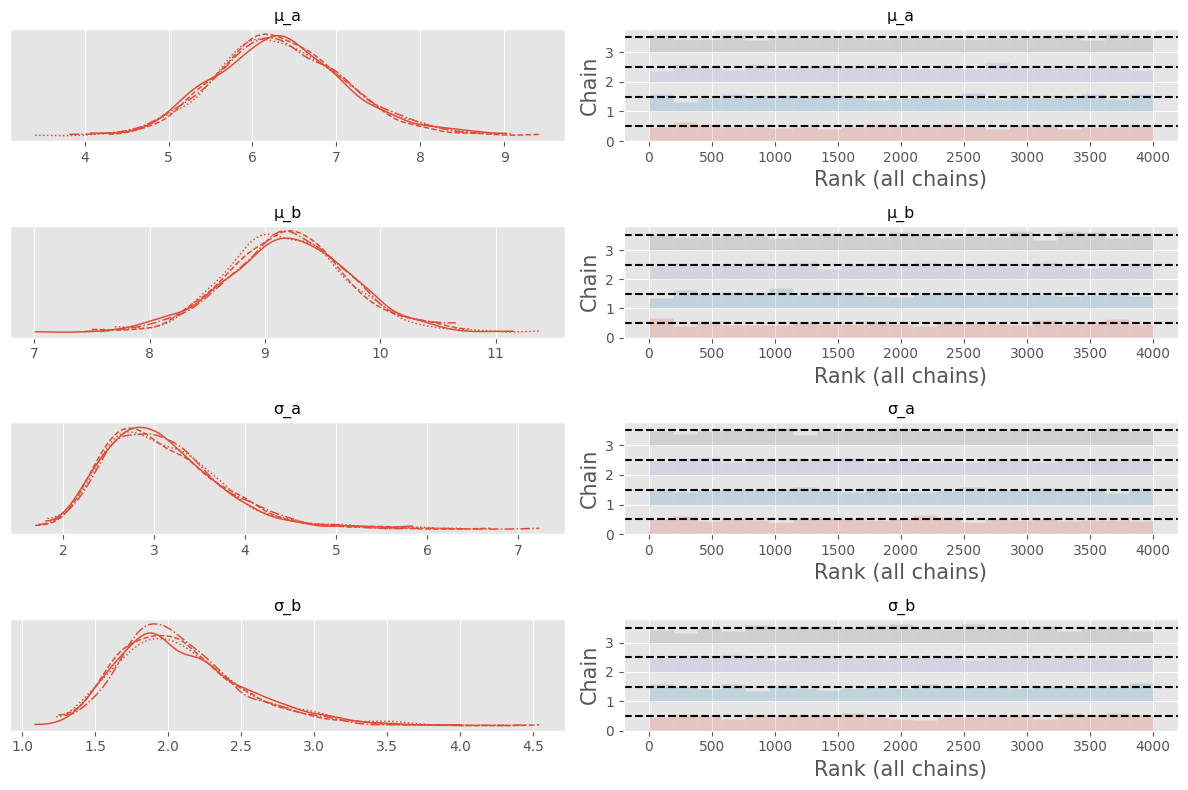

In [4]:
pm.plot_trace( trace, kind="rank_bars" )
plt.tight_layout()

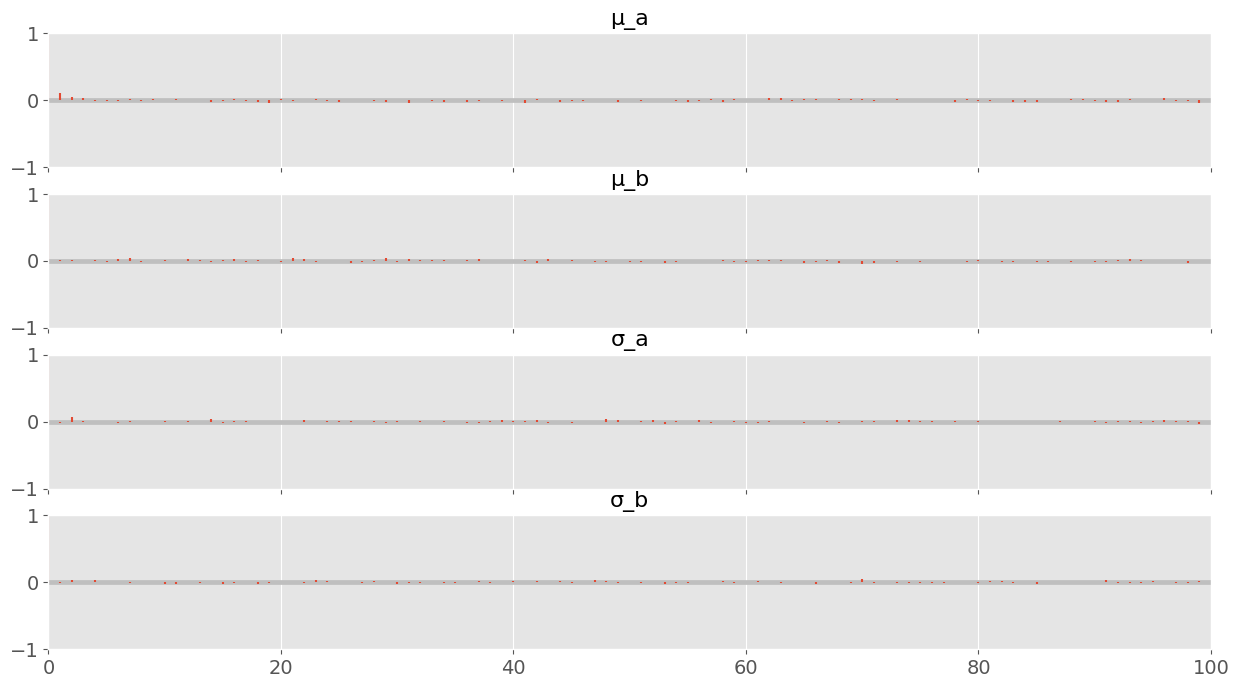

In [5]:
pm.plot_autocorr( trace, combined=True, grid=(4,1), figsize=(15,8) );

In [6]:
pm.rhat( trace )

<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ_a      float64 1.001
    μ_b      float64 1.001
    σ_a      float64 1.0
    σ_b      float64 1.002

In [7]:
pm.ess( trace )

<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ_a      float64 3.016e+03
    μ_b      float64 3.806e+03
    σ_a      float64 4.051e+03
    σ_b      float64 3.988e+03

Looks all good!

## Step 5: Assess Difference

Compute and visualize differences:

Text(0.5, 0, '$\\mu_b - \\mu_a$')

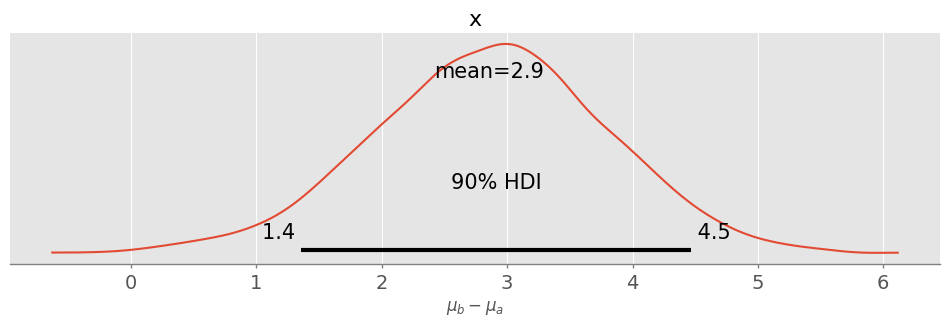

In [8]:
diff = trace.posterior.μ_b - trace.posterior.μ_a
pm.plot_posterior(  diff, hdi_prob=0.9 )
plt.xlabel("$\mu_b - \mu_a$")

Mean difference:

In [9]:
np.round( np.mean( diff ), 1 ).values

array(2.9)

90% HDI:

In [10]:
pm.hdi( diff, hdi_prob=0.9 )

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    x        (hdi) float64 1.358 4.466

Posterior belief that difference is positive:

In [11]:
np.mean( diff.values > 0 )

0.998

## Step 6: Prediction

Make predictions with PyMC:

In [12]:
with railway_counter_queue_model:
    y_new = pm.Normal('y_new', mu=μ_a, sigma=σ_a)
    predictions = pm.sample_posterior_predictive(trace, var_names=["y_new"])

Sampling: [y_new]


Plot result:

<Axes: title={'center': 'y_new'}>

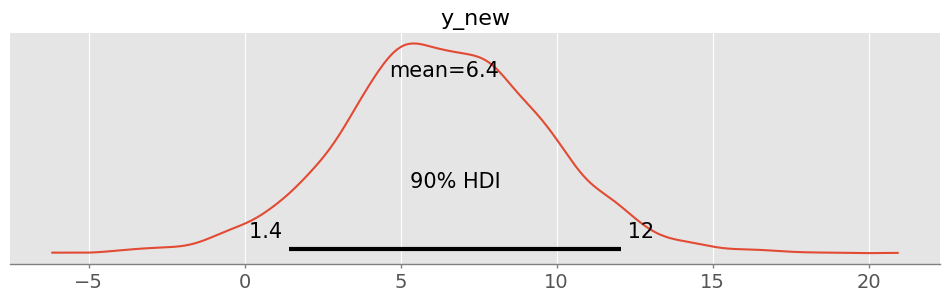

In [13]:
pm.plot_posterior( predictions, group="posterior_predictive", hdi_prob=0.9 )

(considerable uncertainty!)

Aleatoric vs epistemic uncertainty:

In [14]:
aleatoric_var = np.mean( trace.posterior.σ_a.values**2 )
epistemic_var = np.var( trace.posterior.μ_a.values )
pred_var = np.var( predictions.posterior_predictive.y_new.values )
np.round( np.array( [aleatoric_var, epistemic_var] ) / (aleatoric_var+epistemic_var) * 100, 1 )

array([94.3,  5.7])